In [1]:
# Reimplementing https://github.com/Genentech/nodags-flows/blob/master/notebooks/perturb_cite_seq_experiments.ipynb

In [2]:
import numpy as np
import torch
import os
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
from scipy.stats import ranksums
from pathlib import Path

from bicycle.nodags_files.nodags import resflow_train_test_wrapper
import pytorch_lightning as pl

pl.seed_everything(42)

Global seed set to 42


42

In [3]:
DATA_PATH = Path("/data/m015k/data/bicycle/data")

In [4]:
intervention_sets = np.load(
    DATA_PATH / "nodags_data/cocult/training_data/intervention_sets.npy",
    allow_pickle=True,
)
datasets = [
    np.load(DATA_PATH / "nodags_data/cocult/training_data/dataset_{}.npy".format(t))
    for t in range(len(intervention_sets))
]

In [5]:
valid_intervention_sets = np.load(
    DATA_PATH / "nodags_data/cocult/validation_data/intervention_sets.npy",
    allow_pickle=True,
)
valid_datasets = [
    np.load(DATA_PATH / "nodags_data/cocult/validation_data/dataset_{}.npy".format(t))
    for t in range(len(valid_intervention_sets))
]

In [6]:
training_datasets = datasets
training_interventions = intervention_sets

# validation_datasets = datasets[-6:]
# validation_interventions = intervention_sets[-6:]

total_data = 0

for data in training_datasets:
    total_data += len(data)

print(total_data)

11024


In [7]:
import scanpy as sc
import scipy.sparse as sp

adata = sc.read_h5ad(DATA_PATH / "SCP1064/ready/cocult/gene_filtered_adata.h5ad")
data = sp.csr_matrix.toarray(adata.X)

genes = adata.var.index

In [8]:
obs_data = data[adata.obs["targets"] == "", :]
obs_data_mu = obs_data.mean(axis=0)

# obs_data_mu

# Center the data with obs_data_mean
# FIXME: MARTIN
training_data_cent = [td - obs_data_mu for td in training_datasets]
valid_datasets_cent = [td - obs_data_mu for td in valid_datasets]

In [9]:
nodags_wrapper = resflow_train_test_wrapper(
    n_nodes=61,
    batch_size=64,
    l1_reg=True,
    lambda_c=1e-3,
    n_lip_iter=5,
    fun_type="gst-mlp",
    act_fun="relu",
    epochs=100,
    lr=1e-2,
    lip_const=0.99,
    optim="adam",
    inline=True,
    n_hidden=0,
    lin_logdet=False,
    dag_input=False,
    thresh_val=0.05,
    upd_lip=True,
    centered=True,
)

Initializing the model
Number of Parameters : 7505


In [10]:
nodags_wrapper.train(training_data_cent, training_interventions, batch_size=256)

Starting Training


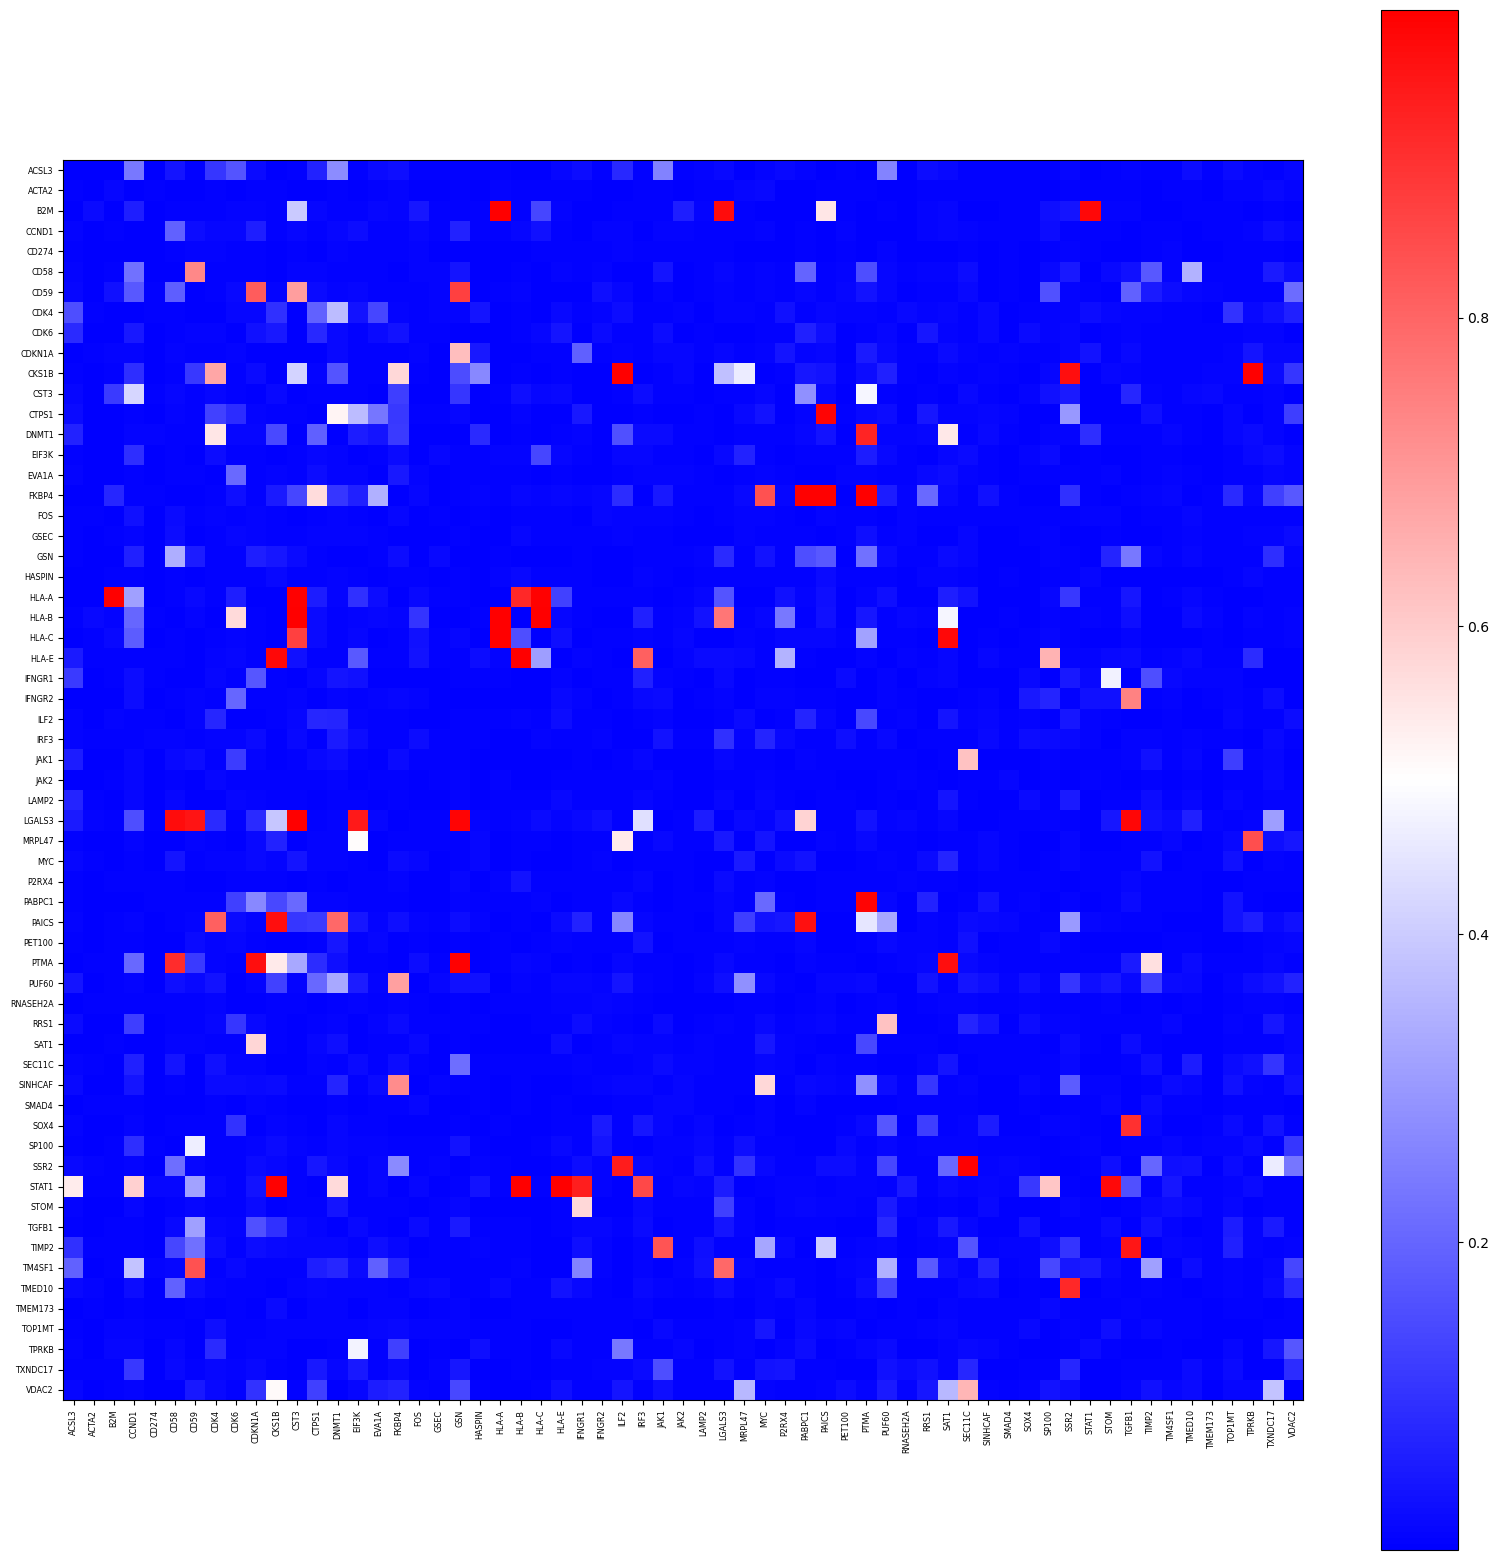

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(20, 20))

im = axs.imshow(nodags_wrapper.get_adjacency(), cmap="bwr")
axs.set_xticks(range(61))
axs.set_xticklabels(genes, rotation=90, size="xx-small")
axs.set_yticks(range(61))
axs.set_yticklabels(genes, size="xx-small")

cbar = plt.colorbar(im)

In [12]:
import seaborn

In [13]:
import pandas as pd

df = pd.DataFrame(columns=genes)
for i in range(61):
    df[genes[i]] = nodags_wrapper.get_adjacency()[:, i]

df.index = genes

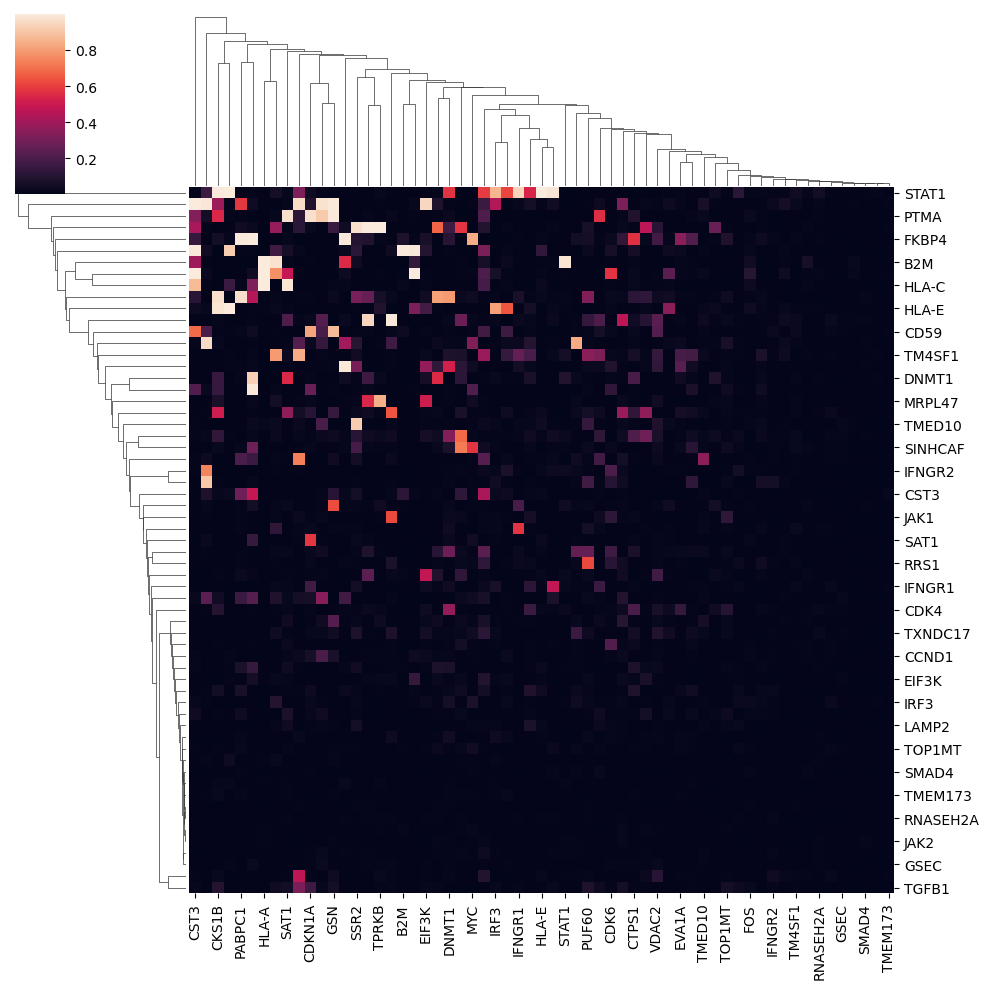

In [14]:
seaborn.clustermap(df)

In [15]:
val_nll = nodags_wrapper.predictLikelihood(valid_datasets_cent, valid_intervention_sets)

print(np.mean(val_nll))

1.3416416814418437


In [66]:
predictions = nodags_wrapper.forwardPass(valid_datasets_cent)

In [67]:
np.mean([np.abs(data - pred).mean(axis=0) for data, pred in zip(valid_datasets_cent, predictions)])

0.7911122565146961

In [68]:
# Compute MAE but leave out the gene that was perturbed
def compute_mae(predictions, datasets, intervention_sets):
    mae_per_intervention_set = []
    for i in range(len(predictions)):  # DATASET
        for j in range(predictions[i].shape[1]):  # N_GENES
            if j not in intervention_sets[i]:  # Skip the perturbed gene
                mae_per_intervention_set.append(np.abs(predictions[i][:, j] - datasets[i][:, j]))

    mae_per_intervention_set = np.concatenate([np.array(x) for x in mae_per_intervention_set], axis=0)
    mae_per_intervention_set = np.mean(mae_per_intervention_set)

    return mae_per_intervention_set

In [69]:
compute_mae(predictions, valid_datasets_cent, valid_intervention_sets)

0.7771760707110642

In [71]:
x_distribution_kwargs = {"std": 0.1}
x_distribution_kwargs_str = "_".join([f"{v}" for v in x_distribution_kwargs.values()])
x_distribution_kwargs_str

'0.1'